<a href="https://colab.research.google.com/github/hassanjavaid07/CS500-Generative-AI-and-LLM/blob/main/Assignment02/assignment02_MSCS23001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

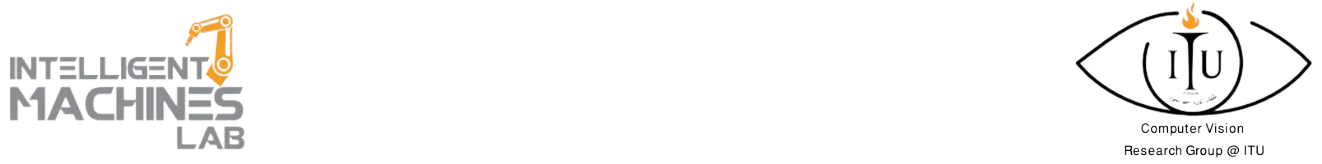

## Generative AI & LLM Fall 2024
## Assignment 2: Implementing a VAE using CNN and pytorch

In this assignment, you will implement a VAE using CNN and pytorch. You will use the MNIST dataset for this assignment.

**You will need to implement the following:**

1. The VAE Model
2. Kaiming Initialization also known as He Initialization (https://paperswithcode.com/method/he-initialization)
3. The VAE loss function
4. The forward pass
5. The training loop
6. The evaluation loop
7. The sampling loop
8. Visualize the latent space


**Guidelines:**

1. Use this notebook as a template to implement the VAE model.
2. Try your best to avoid using ChatGPT or any other LLM to complete this assignment.
3. If you get stuck, please reach out at `manzoor.rohan97@gmail.com`
4. Ensure proper formatting of the code.
5. While you will be implementing the assignment on Colab, you are also required to upload the project to github and share the link with us.


**The assignment will be evaluated based on the following criteria:**

| Criteria                | Marks |
|-------------------------|-------|
| 1. VAE model            | 2.5   |
| 2. Training Loop        | 2.5   |
| 3. Correct Sampling     | 2.0   |
| 4. Viva                 | 3.0   |
| Total                   | 10.0  |


Name: `Hassan Javaid`

Reg No: `MSCS23001`

Github Link: `https://github.com/hassanjavaid07/CS500-Generative-AI-and-LLM/blob/main/Assignment02/assignment02_MSCS23001.ipynb`

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# Model Definition

In [2]:
# Implements Kaiming initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')


# Implements the VAE-CNN model
class CNN_VAE(nn.Module):
    def __init__(self, input_channels=1, h_dims=[32, 64], latent_dims=2):
        """
        Initializes the CNN_VAE model.

        Args:
            input_channels (int): Number of input channels (e.g., 1 for grayscale images).
            h_dims (list): A list defining the number of output channels for each convolutional layer in the encoder.
            latent_dims (int): Dimensionality of the latent space.
        """
        super(CNN_VAE, self).__init__()

        self.h_dims = h_dims
        self.latent_dims = latent_dims


        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, self.h_dims[0], kernel_size=3, stride=2, padding=1), #14x14
            nn.ReLU(),
            nn.Conv2d(self.h_dims[0], self.h_dims[1], kernel_size=3, stride=2, padding=1), #7x7
            nn.ReLU()
        )

        self.enc_out = self.h_dims[1] * 7 * 7 # from encoder

        self.mean_layer = nn.Linear(self.enc_out, self.latent_dims)
        self.logvar_layer = nn.Linear(self.enc_out, self.latent_dims)

        self.reshape = nn.Linear(self.latent_dims, self.enc_out) # b4 decoder

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.h_dims[1], self.h_dims[0], 3,2,1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.h_dims[0], input_channels, 4,2,0),
            nn.Sigmoid(),
        )

    def reparametrize(self, mu, logvar):
        """
        Reparameterization trick to sample from the latent space.

        Args:
            mu (torch.Tensor): Mean of the latent distribution.
            logvar (torch.Tensor): Log variance of the latent distribution.

        Returns:
            torch.Tensor: Sampled latent variable from the distribution defined by mu and logvar.
        """
        std = logvar.mul(0.5).exp_()
        mu_size = mu.size()
        gaussian = torch.randn(mu_size)
        return mu + std * gaussian

    def encode(self, x):
        """
        Encodes the input data into the latent space representation.

        Args:
            x (torch.Tensor): Input data (e.g., images) to be encoded.

        Returns:
            tuple: A tuple containing:
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flattening to size [bs, 64x7x7]
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def decode(self, z):
        """
        Decodes the latent representation back to the original data space.

        Args:
            z (torch.Tensor): Latent representation to be decoded.

        Returns:
            torch.Tensor: Reconstructed data from the latent representation.
        """
        z = self.reshape(z)
        z = z.view(z.size(0), self.h_dims[1], 7, 7) # Unflattening to [bs, 64, 7, 7]
        return self.decoder(z)

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input data (e.g., images) for reconstruction.

        Returns:
            tuple: A tuple containing:
                - x_reconstructed (torch.Tensor): Reconstructed input data.
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        mean, log_var = self.encode(x)
        z = self.reparametrize(mean, log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mean, log_var


# Usage
INPUT_CHANNELS = 1
INPUT_SIZE = 28
model = CNN_VAE(input_channels=INPUT_CHANNELS)
model.apply(weights_init)
output, mu, logvar = model.forward(torch.randn((1, INPUT_CHANNELS, INPUT_SIZE, INPUT_SIZE)))
print(output.shape)

torch.Size([1, 1, 28, 28])


# Dataset Loading

In [3]:
# Hyper-parameters
# you can change these to see how the model performs
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
INPUT_DIMS = 1
HID_DIMS = [32, 64]
Z_DIMS = 20
NUM_EPOCHS = 2
LR = 3e-4
BATCH_SIZE = 64
VAL_AFTER = 800

In [4]:
# Loading dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(mnist_train))
valid_size = len(mnist_train) - train_size
train_dataset, valid_dataset = random_split(mnist_train, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12554390.99it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 377408.56it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3187969.33it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10496159.10it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def plot_image(img, nrow=10):
    plt.figure(figsize=(10, 6))
    plt.imshow(make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

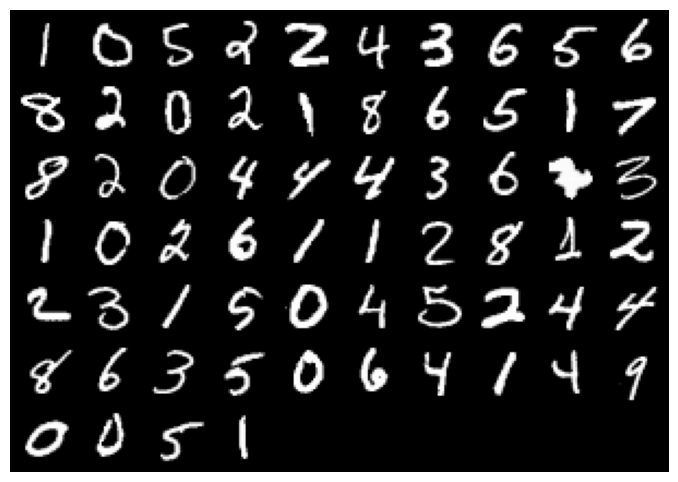

In [6]:
# TODO: Use the plot_image function to plot the images
img, _ = next(iter(train_loader))
plot_image(img)

# Training Loop

In [7]:
# Define VAE loss
def vae_loss(reconstructed_x, x, mu, logvar):
    criterion = torch.nn.BCELoss(reduction='sum')
    reconstruction_loss = criterion(reconstructed_x, x)
    KLD = - 0.5 * torch.sum(1+ logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + KLD


In [8]:
# Instructions:
# 1. Initialize the model and the optimizer. You will be using Adam optimizer
# 2. Implement a training loop that iterates over the training data, performs forward and backward passes, and updates the model parameters.
# 3. Implement a validation loop that evaluates the model on the validation data.
# 4. Implement a progress bar to visualize the training progress.
# 5. Store your training and validation losses in train_losses and eval_losses respectively.

model = CNN_VAE(INPUT_DIMS, HID_DIMS, Z_DIMS).to(DEVICE)
model.apply(weights_init) # Apply weights to the model

optimizer = optim.Adam(model.parameters(), lr=LR)
model = model.to(DEVICE)

train_losses = []
eval_losses = []
NUM_EPOCHS = 30


for epoch in range(NUM_EPOCHS):
    # Training loop
    model.train()
    train_loss = 0

    with tqdm(train_loader, unit="batch") as t_bar:
        for batch_idx, (data, _) in enumerate(t_bar):
            data = data.to(DEVICE)

            optimizer.zero_grad()
            reconstructed, mu, logvar = model(data)

            loss = vae_loss(reconstructed, data, mu, logvar)
            loss.backward()

            train_loss += loss.item()
            optimizer.step()

            t_bar.set_description(f'Training: Epoch {epoch+1}')
            t_bar.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    val_loss = 0

    with tqdm(valid_loader, unit="batch") as v_bar:
        with torch.no_grad():
            for data, _ in v_bar:
                data = data.to(DEVICE)
                reconstructed, mu, logvar = model(data)

                loss = vae_loss(reconstructed, data, mu, logvar)
                val_loss += loss.item()

                v_bar.set_description('Validation')
                v_bar.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    eval_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}: Train loss = {avg_train_loss:.4f}, Validation loss = {avg_val_loss:.4f}\n')

Validation: 100%|██████████| 188/188 [00:05<00:00, 32.65batch/s, loss=4.33e+3]


Epoch 1/30: Train loss = 180.2393, Validation loss = 132.3844



Validation: 100%|██████████| 188/188 [00:05<00:00, 32.12batch/s, loss=4.03e+3]


Epoch 2/30: Train loss = 126.8325, Validation loss = 123.2652



Validation: 100%|██████████| 188/188 [00:05<00:00, 32.95batch/s, loss=3.87e+3]


Epoch 3/30: Train loss = 120.9038, Validation loss = 118.9972



Validation: 100%|██████████| 188/188 [00:05<00:00, 34.17batch/s, loss=3.79e+3]


Epoch 4/30: Train loss = 117.2924, Validation loss = 116.0364



Validation: 100%|██████████| 188/188 [00:05<00:00, 34.40batch/s, loss=3.73e+3]


Epoch 5/30: Train loss = 114.7636, Validation loss = 113.7722



Validation: 100%|██████████| 188/188 [00:05<00:00, 35.73batch/s, loss=3.69e+3]


Epoch 6/30: Train loss = 112.9159, Validation loss = 112.1320



Validation: 100%|██████████| 188/188 [00:05<00:00, 35.86batch/s, loss=3.61e+3]


Epoch 7/30: Train loss = 111.3778, Validation loss = 111.0246



Validation: 100%|██████████| 188/188 [00:05<00:00, 36.03batch/s, loss=3.56e+3]


Epoch 8/30: Train loss = 110.2281, Validation loss = 109.8173



Validation: 100%|██████████| 188/188 [00:05<00:00, 35.11batch/s, loss=3.56e+3]


Epoch 9/30: Train loss = 109.2990, Validation loss = 109.0577



Validation: 100%|██████████| 188/188 [00:05<00:00, 34.91batch/s, loss=3.54e+3]


Epoch 10/30: Train loss = 108.5856, Validation loss = 108.3557



Validation: 100%|██████████| 188/188 [00:05<00:00, 33.56batch/s, loss=3.52e+3]


Epoch 11/30: Train loss = 107.9938, Validation loss = 107.8622



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.80batch/s, loss=3.5e+3]


Epoch 12/30: Train loss = 107.5004, Validation loss = 107.3623



Validation: 100%|██████████| 188/188 [00:06<00:00, 30.78batch/s, loss=3.53e+3]


Epoch 13/30: Train loss = 107.0157, Validation loss = 106.9154



Validation: 100%|██████████| 188/188 [00:06<00:00, 29.11batch/s, loss=3.5e+3]


Epoch 14/30: Train loss = 106.6489, Validation loss = 106.8287



Validation: 100%|██████████| 188/188 [00:06<00:00, 31.19batch/s, loss=3.54e+3]


Epoch 15/30: Train loss = 106.3296, Validation loss = 106.5517



Validation: 100%|██████████| 188/188 [00:05<00:00, 32.32batch/s, loss=3.47e+3]


Epoch 16/30: Train loss = 106.0385, Validation loss = 106.2761



Validation: 100%|██████████| 188/188 [00:05<00:00, 32.19batch/s, loss=3.46e+3]


Epoch 17/30: Train loss = 105.7576, Validation loss = 105.8828



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.42batch/s, loss=3.44e+3]


Epoch 18/30: Train loss = 105.5105, Validation loss = 105.9329



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.50batch/s, loss=3.43e+3]


Epoch 19/30: Train loss = 105.3067, Validation loss = 105.6567



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.71batch/s, loss=3.44e+3]


Epoch 20/30: Train loss = 105.1371, Validation loss = 105.3929



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.37batch/s, loss=3.46e+3]


Epoch 21/30: Train loss = 104.9338, Validation loss = 105.2304



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.51batch/s, loss=3.48e+3]


Epoch 22/30: Train loss = 104.7329, Validation loss = 105.0499



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.49batch/s, loss=3.4e+3]


Epoch 23/30: Train loss = 104.6326, Validation loss = 104.8508



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.83batch/s, loss=3.43e+3]


Epoch 24/30: Train loss = 104.4290, Validation loss = 104.5972



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.62batch/s, loss=3.43e+3]


Epoch 25/30: Train loss = 104.2788, Validation loss = 104.5036



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.48batch/s, loss=3.45e+3]


Epoch 26/30: Train loss = 104.1347, Validation loss = 104.5473



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.59batch/s, loss=3.45e+3]


Epoch 27/30: Train loss = 104.0392, Validation loss = 104.4645



Validation: 100%|██████████| 188/188 [00:06<00:00, 31.27batch/s, loss=3.43e+3]


Epoch 28/30: Train loss = 103.9322, Validation loss = 104.2706



Validation: 100%|██████████| 188/188 [00:06<00:00, 31.12batch/s, loss=3.41e+3]


Epoch 29/30: Train loss = 103.8014, Validation loss = 104.1710



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.70batch/s, loss=3.44e+3]

Epoch 30/30: Train loss = 103.6874, Validation loss = 104.1245



In [9]:
# Save the model
torch.save(model.state_dict(), f'model_{NUM_EPOCHS}epochs.pth')

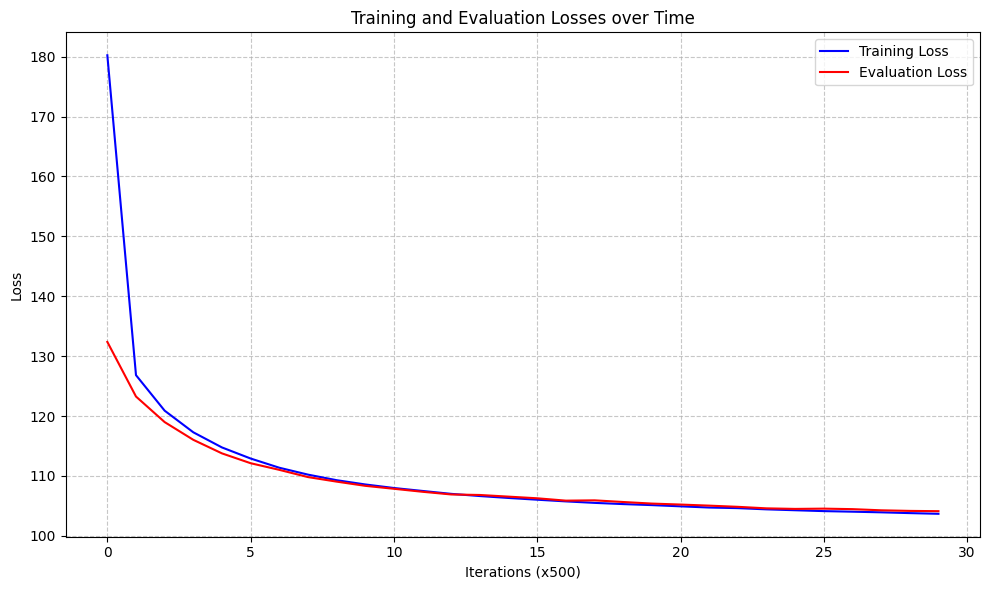

In [10]:
# Visualize your losses as your training progresses

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(eval_losses, label='Evaluation Loss', color='red')
plt.title('Training and Evaluation Losses over Time')
plt.xlabel('Iterations (x500)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Visualizations

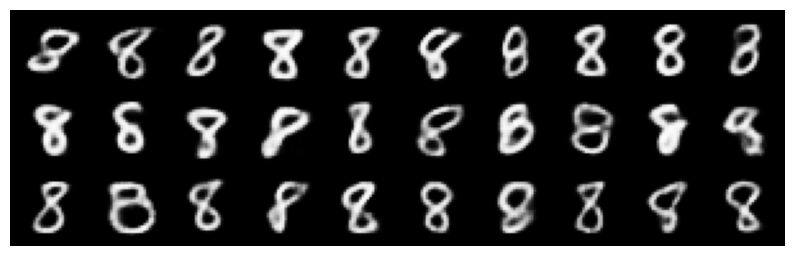

In [11]:
def visualize_generations(model, digit, num_examples):
    model.eval()

    digit_images = [img for img, label in mnist_test if label == digit]

    digit_images_tensor = torch.stack(digit_images)[:num_examples].to(DEVICE)

    with torch.no_grad():
        mu, logvar = model.encode(digit_images_tensor)

    std = torch.exp(0.5 * logvar)
    z_samples = mu + std * torch.randn_like(std)

    with torch.no_grad():
        reconstructed_images = model.decode(z_samples)

    plot_image(reconstructed_images)

# Usage
digit = 8
num_examples = 30
visualize_generations(model, digit, num_examples)


Shape of latents_m: torch.Size([10000, 20])


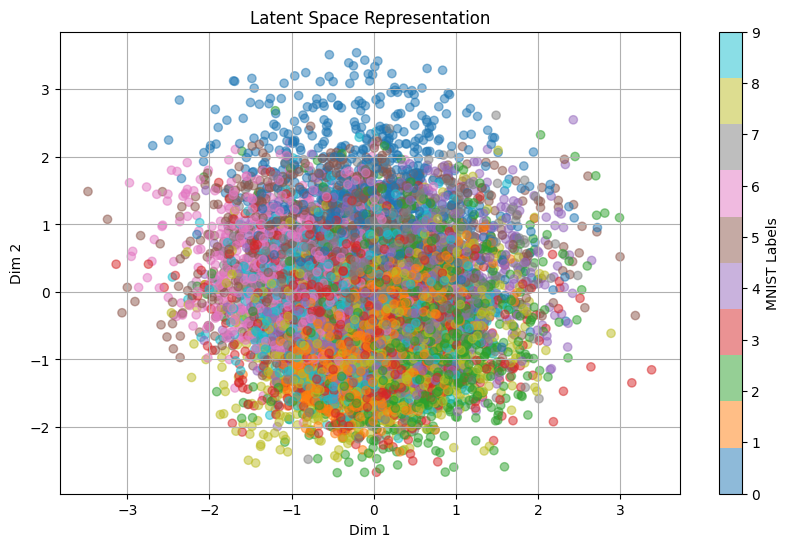

In [12]:
def visualize_latents(dataloader, model):
    model.eval()

    latents_m = []
    labels_m = []

    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(DEVICE)
            _, mu, logvar = model(data)

            latents_m.append(mu.cpu())
            labels_m.append(labels.cpu())

    latents_m = torch.cat(latents_m)
    labels_m = torch.cat(labels_m)

    print(f"Shape of latents_m: {latents_m.shape}")

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(latents_m[:, 0], latents_m[:, 1], c=labels_m, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter, label='MNIST Labels')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.title('Latent Space Representation')
    plt.grid()
    plt.show()

# Usage
visualize_latents(test_loader, model)


In [ ]:
# End of code